In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import cv2

In [2]:
# Carga los datos
X_train = np.load("train_images.npy")
X_train = np.expand_dims(X_train, axis=-1).astype(np.float32)
#X_train = np.load("mnist_train_data.npy") 
# Asegúrate de que las imágenes tengan la forma correcta
#X_train = X_train.astype("float32") / 255.0  # Normaliza las imágenes
#X_train = np.reshape(X_train, (-1, 28, 28, 1))  # Asegúrate de que tengan la forma (num_imagenes, 28, 28, 1)

In [3]:
class Sampling(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = keras.ops.shape(z_mean)[0]
        dim = keras.ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + keras.ops.exp(0.5 * z_log_var) * epsilon


In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation="relu")(x)
z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = keras.layers.Reshape((7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var))
            kl_loss = keras.ops.mean(keras.ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [7]:
# Define el VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# Entrena el VAE
history = vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan
Epoch 10/30
469/469 ━━━━━━━━

<function matplotlib.pyplot.show(close=None, block=None)>

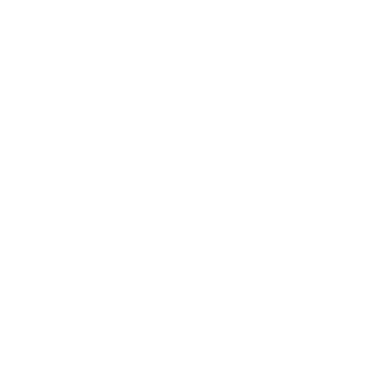

In [8]:
import matplotlib.pyplot as plt
sample = np.array([[-3, 1]], dtype=np.float32)
prediction =  vae.decoder(sample)
plt.figure()
plt.imshow(np.squeeze(prediction))
plt.axis("off")
plt.show